Прогнозирование заказов такси
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Вам нужно:

Загрузить данные и выполнить их ресемплирование по одному часу.
Проанализировать данные.
Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
Проверить данные на тестовой выборке и сделать выводы.
Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly

from sklearn.linear_model import LinearRegression
from catboost import CatBoost
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error  
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

#!pip install Prophet
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly

#!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import statsmodels.api as st
import time
from time import time

C:\Python27\anac\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('C:/Users/анатолий/Documents/datasets/taxi.csv',index_col=['datetime'],parse_dates=['datetime'],\
                                                                                       dayfirst=True)

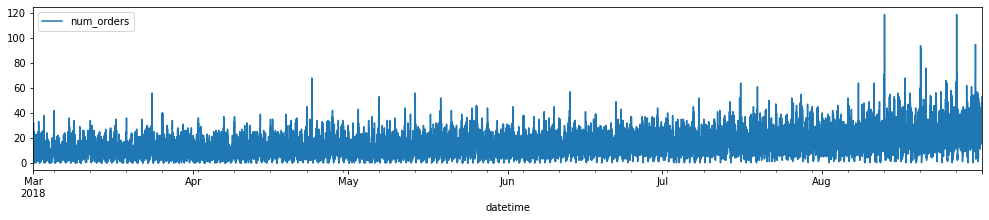

In [3]:
data.plot(figsize=(17,3));

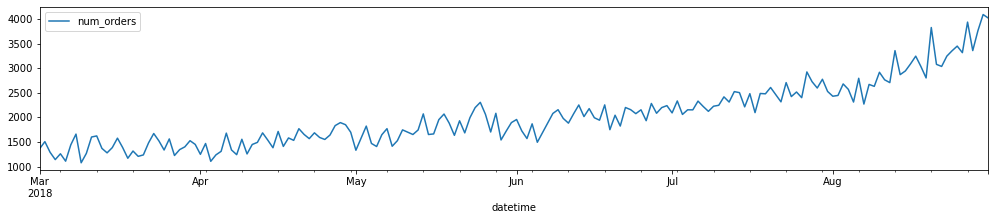

In [4]:
data['2018-03':'2018-08'].resample('1D').sum().plot(figsize=(17,3));


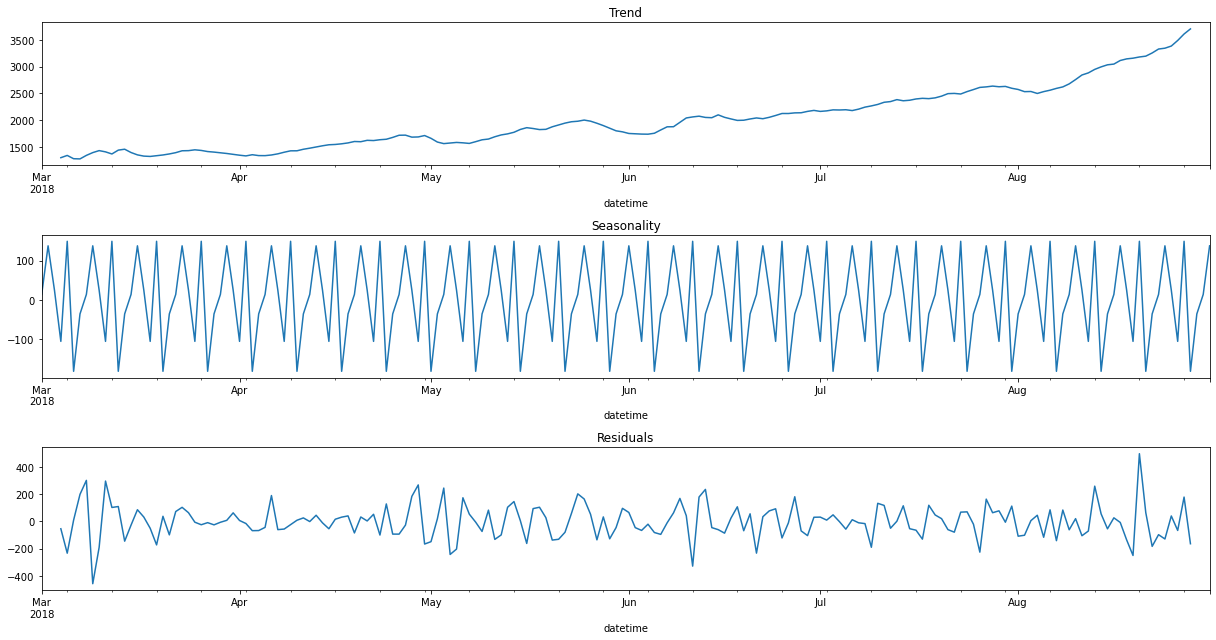

In [5]:
decomposed = seasonal_decompose(data['2018-03':'2018-08'].resample('1D').sum())

plt.figure(figsize=(17, 9))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

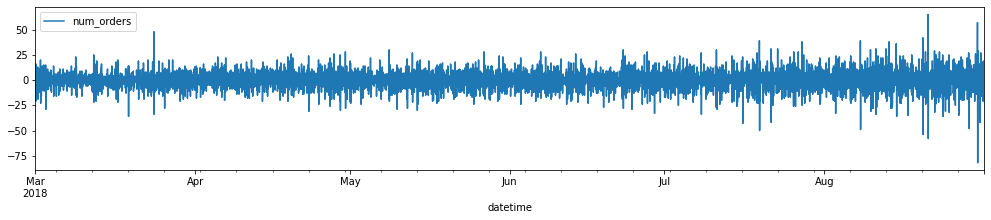

In [6]:
(data - data.shift()).resample('1H').sum().plot(figsize=(17,3));

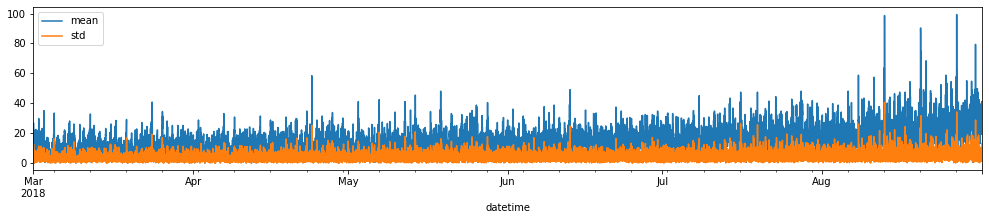

In [7]:
data['mean'] = data['num_orders'].rolling(3).mean()
data['std'] = data['num_orders'].rolling(3).std()
data[['mean','std']].plot(figsize=(17,3));

         PROPHET

In [8]:
df = pd.read_csv('C:/Users/анатолий/Documents/datasets/taxi.csv')
display(df.head())
df.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [9]:
df['datetime']=df['datetime'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d')).astype('datetime64')
df.rename(columns = {'datetime' : 'ds','num_orders' : 'y'},inplace=True)
display(df.head())
df.info()

,ds,y
0,2018-03-01,9
1,2018-03-01,14
2,2018-03-01,28
3,2018-03-01,20
4,2018-03-01,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      26496 non-null  datetime64[ns]
 1   y       26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [10]:
%%time
t0 = time()

Wall time: 0 ns


In [11]:
m = Prophet()
m.fit(df)

15:03:23 - cmdstanpy - INFO - Chain [1] start processing
15:03:33 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
future = m.make_future_dataframe(periods=1)
future.tail()

,ds
180,2018-08-28
181,2018-08-29
182,2018-08-30
183,2018-08-31
184,2018-09-01


Эта процедура перекрестной проверки может быть выполнена автоматически для ряда исторических отсечек с помощью функции. Мы указываем горизонт прогноза (), а затем опционально размер начального периода обучения () и интервал между датами отсечения (). По умолчанию начальный период обучения устанавливается в три раза больше горизонта, а отсечки делаются каждые полгоризона.cross_validationhorizoninitialperiod

In [ ]:
#  кросс-валидация на обучение с горизонтом предсказания N часа
df_cv = cross_validation(m,horizon = '192 hours', initial='384 hours', period='182 hours')
df_cv.head()



Пользовательские отсечки также могут быть предоставлены в виде списка дат для ключевого слова в функции в Python . Например, три отсечки с интервалом в шесть месяцев должны быть переданы аргументу в формате даты, например:cutoffscross_validationcutoffs

In [ ]:
# рассчет метрик модели
df_p = performance_metrics(df_cv)
df_p.head()

#from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [13]:



param_grid = {  
    'changepoint_prior_scale': [0.001,0.01],
    'seasonality_prior_scale': [ 0.1],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='132 hours')#, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)


15:03:34 - cmdstanpy - INFO - Chain [1] start processing
15:03:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/59 [00:00<?, ?it/s]

15:03:41 - cmdstanpy - INFO - Chain [1] start processing
15:03:42 - cmdstanpy - INFO - Chain [1] done processing
15:03:45 - cmdstanpy - INFO - Chain [1] start processing
15:03:45 - cmdstanpy - INFO - Chain [1] done processing
15:03:48 - cmdstanpy - INFO - Chain [1] start processing
15:03:48 - cmdstanpy - INFO - Chain [1] done processing
15:03:52 - cmdstanpy - INFO - Chain [1] start processing
15:03:52 - cmdstanpy - INFO - Chain [1] done processing
15:03:55 - cmdstanpy - INFO - Chain [1] start processing
15:03:55 - cmdstanpy - INFO - Chain [1] done processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:59 - cmdstanpy - INFO - Chain [1] done processing
15:04:02 - cmdstanpy - INFO - Chain [1] start processing
15:04:02 - cmdstanpy - INFO - Chain [1] done processing
15:04:06 - cmdstanpy - INFO - Chain [1] start processing
15:04:06 - cmdstanpy - INFO - Chain [1] done processing
15:04:09 - cmdstanpy - INFO - Chain [1] start processing
15:04:09 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/59 [00:00<?, ?it/s]

15:08:50 - cmdstanpy - INFO - Chain [1] start processing
15:08:50 - cmdstanpy - INFO - Chain [1] done processing
15:08:53 - cmdstanpy - INFO - Chain [1] start processing
15:08:53 - cmdstanpy - INFO - Chain [1] done processing
15:08:57 - cmdstanpy - INFO - Chain [1] start processing
15:08:57 - cmdstanpy - INFO - Chain [1] done processing
15:09:00 - cmdstanpy - INFO - Chain [1] start processing
15:09:00 - cmdstanpy - INFO - Chain [1] done processing
15:09:03 - cmdstanpy - INFO - Chain [1] start processing
15:09:04 - cmdstanpy - INFO - Chain [1] done processing
15:09:07 - cmdstanpy - INFO - Chain [1] start processing
15:09:07 - cmdstanpy - INFO - Chain [1] done processing
15:09:10 - cmdstanpy - INFO - Chain [1] start processing
15:09:11 - cmdstanpy - INFO - Chain [1] done processing
15:09:14 - cmdstanpy - INFO - Chain [1] start processing
15:09:15 - cmdstanpy - INFO - Chain [1] done processing
15:09:18 - cmdstanpy - INFO - Chain [1] start processing
15:09:18 - cmdstanpy - INFO - Chain [1]

   changepoint_prior_scale  seasonality_prior_scale      rmse
0                    0.001                      0.1  8.392027
1                    0.010                      0.1  8.342891


In [14]:
best_params = all_params[np.argmin(rmses)]
print(best_params)


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


In [32]:
m = Prophet(**best_params)
m.fit(df)
future = m.make_future_dataframe(periods=5)

15:19:32 - cmdstanpy - INFO - Chain [1] start processing
15:19:37 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
#  кросс-валидация на обучение с горизонтом предсказания 91 часа
df_cv = cross_validation(m,horizon = '397 hours', initial='582 hours', period='264 hours')
df_cv.head()

  0%|          | 0/13 [00:00<?, ?it/s]

15:19:39 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing
15:19:45 - cmdstanpy - INFO - Chain [1] start processing
15:19:46 - cmdstanpy - INFO - Chain [1] done processing
15:19:51 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing
15:19:57 - cmdstanpy - INFO - Chain [1] start processing
15:19:58 - cmdstanpy - INFO - Chain [1] done processing
15:20:03 - cmdstanpy - INFO - Chain [1] start processing
15:20:05 - cmdstanpy - INFO - Chain [1] done processing
15:20:10 - cmdstanpy - INFO - Chain [1] start processing
15:20:12 - cmdstanpy - INFO - Chain [1] done processing
15:20:16 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:25 - cmdstanpy - INFO - Chain [1] done processing
15:20:30 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-04-05,10.351471,1.629766,18.495794,13,2018-04-04 11:00:00
1,2018-04-05,10.351471,2.425104,18.600976,13,2018-04-04 11:00:00
2,2018-04-05,10.351471,1.898832,18.757387,8,2018-04-04 11:00:00
3,2018-04-05,10.351471,2.104683,17.888191,11,2018-04-04 11:00:00
4,2018-04-05,10.351471,1.915965,18.445299,14,2018-04-04 11:00:00


In [34]:
# напечатаем метрики модели
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days 13:00:00,61.034077,7.812431,6.051418,0.342321,0.475155,0.759679
1,2 days 13:00:00,62.941679,7.933579,6.109195,0.351955,0.468018,0.759332
2,3 days 13:00:00,64.436138,8.027212,6.085734,0.342452,0.462757,0.769012
3,4 days 13:00:00,63.079883,7.942284,6.089854,0.340104,0.471345,0.763824
4,5 days 13:00:00,73.723935,8.586264,6.319197,0.354526,0.474596,0.756693


C:\Python27\anac\lib\site-packages\prophet\plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Python27\anac\lib\site-packages\prophet\plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


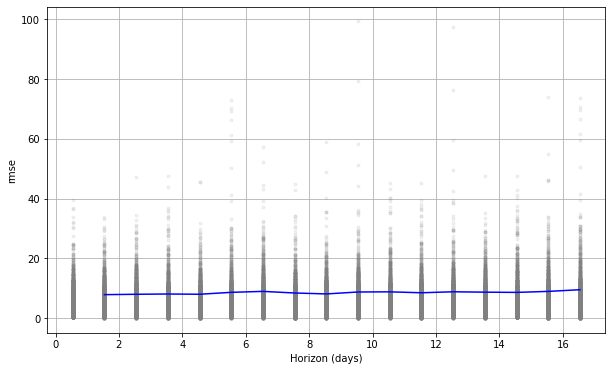

In [35]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [36]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
184,2018-09-01,25.056310,14.972091,35.014337
185,2018-09-02,24.370392,13.632653,35.008293
186,2018-09-03,26.368910,16.038894,37.382944
187,2018-09-04,24.286190,13.246231,34.842983
188,2018-09-05,25.532899,15.254406,35.531666


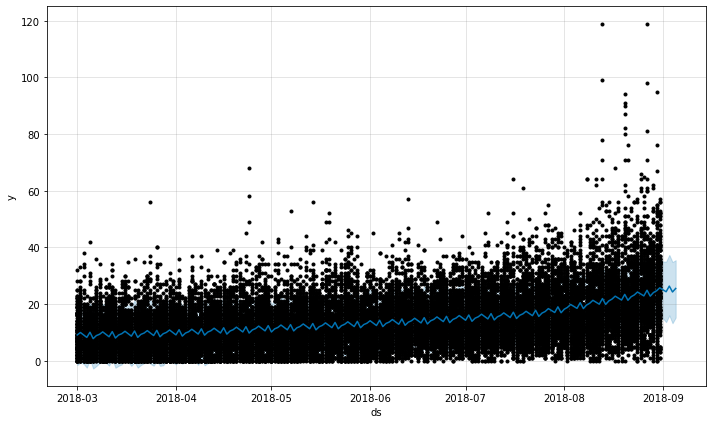

In [37]:
fig1 = m.plot(forecast)

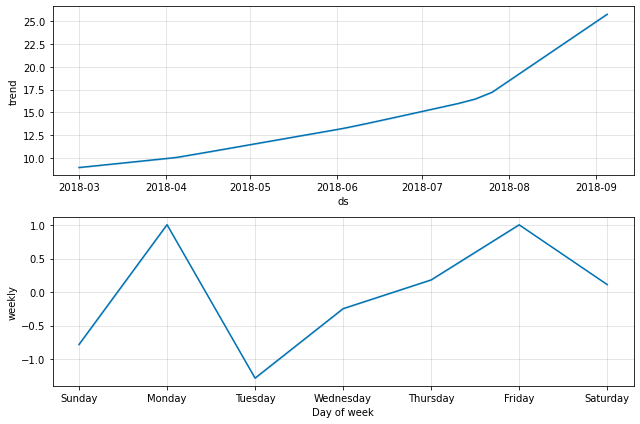

In [38]:
fig2 = m.plot_components(forecast)

In [39]:
f = time()-t0
print('ВРЕМЯ РАБОТЫ ПРОГРАММЫ ', f)

ВРЕМЯ РАБОТЫ ПРОГРАММЫ  1079.6427104473114


In [23]:

#plot_plotly(m, forecast)

In [24]:
#plot_components_plotly(m, forecast)